# Tarea 1 - Taller de Astronomía

### Observaciones: 0310g, 0310r

In [23]:
import os 
import pandas as pd
import numpy as np
import shutil
import glob
import ccdproc
import matplotlib.pyplot as plt
import astropy.units as u
from matplotlib.cm import get_cmap
from scipy.optimize import minimize, curve_fit
from astropy.coordinates import SkyCoord
from astropy.nddata import CCDData
from astropy.io import fits
from astropy.visualization import LogStretch, ImageNormalize
from astropy.wcs import WCS
from astropy.visualization.mpl_normalize import simple_norm
from astropy.stats import sigma_clipped_stats
from photutils import DAOStarFinder, CircularAperture, CircularAnnulus, aperture_photometry


## Cargar y plotear ambas observaciones

In [24]:
path_g = '0310g.fits'
path_r = '0310r.fits'
hdulist_g = fits.open(path_g)
hdulist_r = fits.open(path_r)
files = [hdulist_g, hdulist_r]

In [25]:
hdulist_g[0].header

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                  -32 / Bits per pixel                                 
NAXIS   =                    2 / Number of axes                                 
NAXIS1  =                 2112 / Axis length                                    
NAXIS2  =                 4644 / Axis length                                    
EXTEND  =                    T / File may contain extensions                    
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
DATE    = '2022-08-09T17:22:54' / Date FITS file was generated                  
IRAF-TLM= '2022-08-09T17:22:54' / Time of last modification                     
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
COMMENT                                                                         
COMMENT Observation Summary 

In [26]:
hdulist_r[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 2112 / length of data axis 1                          
NAXIS2  =                 4644 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
COMMENT                                                                         
COMMENT Observation Summary                                                     
COMMENT -------------------                                                     
CMMTOBS = 'N/A     '                                                            
CMMTSEQ = 'SINGLE[1/1] - Ref

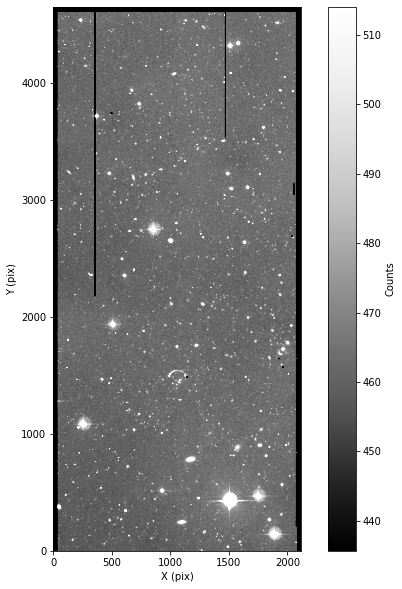

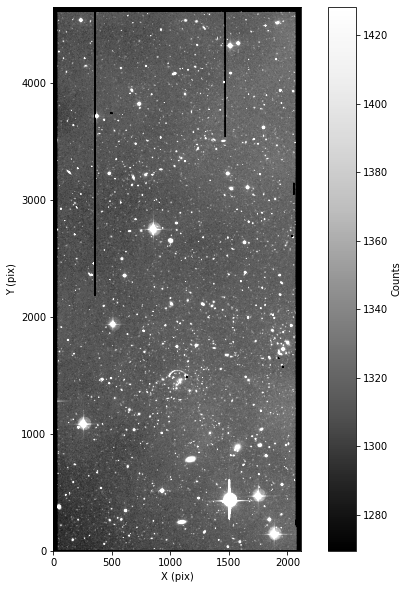

In [27]:
def plot_image(image):
    norm = simple_norm(image, min_percent=10, max_percent=99)
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(image, norm=norm, origin="lower", cmap="Greys_r")
    fig.colorbar(im, ax=ax, label="Counts")
    ax.set_xlabel("X (pix)")
    ax.set_ylabel("Y (pix)")
    return fig, ax

for file in files:
    data = file[0].data
    plot_image(data)

## Datos y estadística de las detecciones

In [28]:
def mean_median_std(hdulist):
    data = hdulist[0].data
    mean, median, std = sigma_clipped_stats(data, sigma=4.0)
    return mean, median, std

mean_g, median_g, std_g = mean_median_std(hdulist_g)
mean_r, median_r, std_r = mean_median_std(hdulist_r)

print(mean_g, median_g, std_g)
print(mean_r, median_r, std_r)

463.31137 463.5 18.498884
1317.1127 1316.0312 31.884878


In [29]:
data_g = hdulist_g[0].data
data_r = hdulist_r[0].data

### Banda g

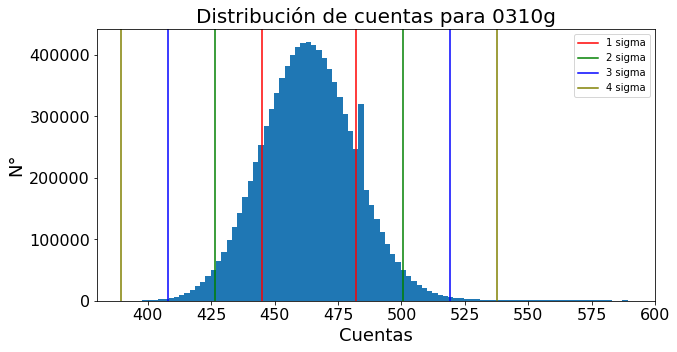

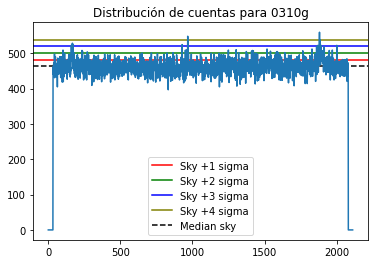

In [32]:
mask_g = (data_g > 250) & (data_g < 900)

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(data_g[mask_g], bins=300)
ax.axvline(median_g + std_g, c='r', label = "1 sigma")
ax.axvline(median_g - std_g, c='r')
ax.axvline(median_g + 2*std_g, c='g', label = "2 sigma")
ax.axvline(median_g - 2*std_g, c='g')
ax.axvline(median_g + 3*std_g, c='b', label = "3 sigma")
ax.axvline(median_g - 3*std_g, c='b')
ax.axvline(median_g + 4*std_g, c='olive', label = "4 sigma")
ax.axvline(median_g - 4*std_g, c='olive')
ax.set_xlim(380, 600)
ax.set_xlabel("Cuentas", fontsize=18)
ax.set_ylabel("N°",fontsize=18)
ax.set_title("Distribución de cuentas para 0310g", fontsize=20)
ax.tick_params('both', labelsize=16)
ax.legend()

cut = data_g[100]
fig, ax = plt.subplots()
ax.axhline(median_g + std_g, c='r', label = "Sky +1 sigma")
ax.axhline(median_g + 2*std_g, c='g', label = "Sky +2 sigma")
ax.axhline(median_g + 3*std_g, c='b', label = "Sky +3 sigma")
ax.axhline(median_g + 4*std_g, c='olive', label = "Sky +4 sigma")
ax.set_title("Distribución de cuentas para 0310g")

ax.axhline(median_g, c='k', linestyle="dashed", label = "Median sky")
ax.legend()
ax.plot(cut)

Text(0.5, 1.0, 'Detecciones por Desviación Estándar en 0310g')

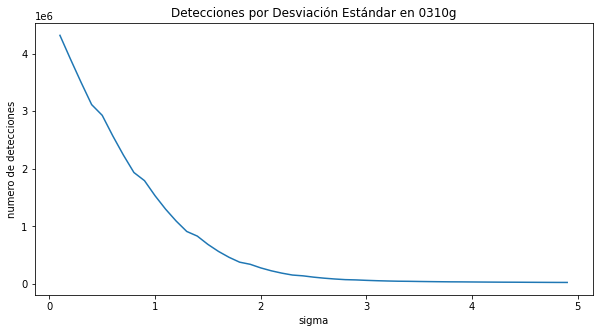

In [33]:
def n_pix(image, mean, sigma, n_sigma):
    return np.sum(image > mean + n_sigma * sigma)

n_sigma = np.arange(0.1, 5, 0.1)
detected_pixels = [n_pix(data_g[mask_g], mean_g, std_g, n_sig) for n_sig in n_sigma]

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(n_sigma, detected_pixels)
ax.set_xlabel("sigma")
ax.set_ylabel("numero de detecciones")
ax.set_title("Detecciones por Desviación Estándar en 0310g")

### Banda r

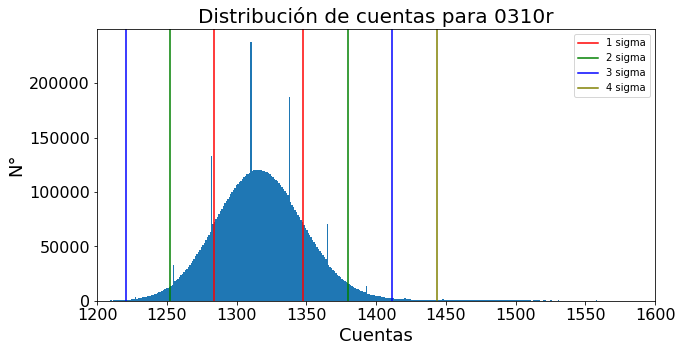

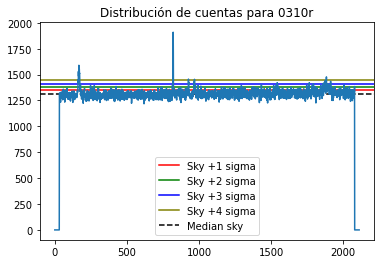

In [34]:
mask_r = (data_r > 600) & (data_r < 2000)


fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(data_r[mask_r], bins=1000)
ax.axvline(median_r + std_r, c='r', label = "1 sigma")
ax.axvline(median_r - std_r, c='r')
ax.axvline(median_r + 2*std_r, c='g', label = "2 sigma")
ax.axvline(median_r - 2*std_r, c='g')
ax.axvline(median_r + 3*std_r, c='b', label = "3 sigma")
ax.axvline(median_r - 3*std_r, c='b')
ax.axvline(median_r + 4*std_r, c='olive', label = "4 sigma")
ax.axvline(median_r - 4*std_r, c='olive')
ax.set_xlim(1200, 1600)
ax.set_xlabel("Cuentas", fontsize=18)
ax.set_ylabel("N°",fontsize=18)
ax.set_title("Distribución de cuentas para 0310r", fontsize=20)
ax.tick_params('both', labelsize=16)
ax.legend()

cut = data_r[100]
fig, ax = plt.subplots()
ax.axhline(median_r + std_r, c='r', label = "Sky +1 sigma")
ax.axhline(median_r + 2*std_r, c='g', label = "Sky +2 sigma")
ax.axhline(median_r + 3*std_r, c='b', label = "Sky +3 sigma")
ax.axhline(median_r + 4*std_r, c='olive', label = "Sky +4 sigma")

ax.axhline(median_r, c='k', linestyle="dashed", label = "Median sky")
ax.set_title("Distribución de cuentas para 0310r")
ax.legend()
ax.plot(cut)

Text(0.5, 1.0, 'Detecciones por Desviación Estándar en 0310r')

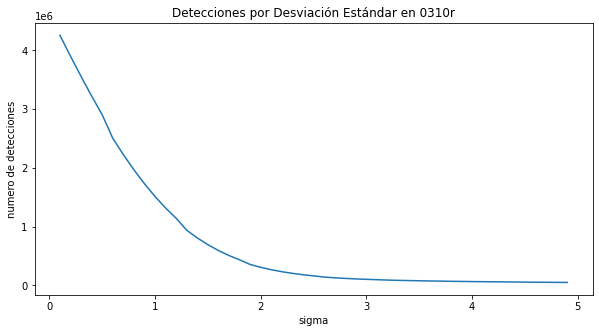

In [35]:
n_sigma = np.arange(0.1, 5, 0.1)
detected_pixels = [n_pix(data_r[mask_r], mean_r, std_r, n_sig) for n_sig in n_sigma]

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(n_sigma, detected_pixels)
ax.set_xlabel("sigma")
ax.set_ylabel("numero de detecciones")
ax.set_title("Detecciones por Desviación Estándar en 0310r")

## Fotometría

### Banda g

In [36]:
daofind = DAOStarFinder(fwhm=1.5, threshold= 4.*std_g)  
sources_dao_g = daofind(data_g - median_g)
print(sources_dao_g)
print(sources_dao_g.columns)

 id     xcentroid      ...        flux                  mag          
--- ------------------ ... ------------------ -----------------------
  1  1265.112819061235 ... 27.565305709838867      -3.600907033336955
  2  1601.882138369255 ... 1.0003952980041504 -0.00042910454827552646
  3 1250.2096191234778 ...  9.260030746459961     -2.4165310717252813
  4 1112.7348123160195 ...  4.624475955963135     -1.6626563144021278
  5 1785.0126062992713 ... 14.671544075012207      -2.916189556586592
  6 1897.1702790592774 ...  1.014572024345398    -0.01570720744132474
  7 1488.7464571977775 ...  29.56670379638672     -3.6770072762431596
  8 309.93191481543386 ...  10.47407054901123      -2.550288737008735
  9   856.387118818139 ...   9.23869800567627     -2.4140269278359043
 10 1600.9237464618368 ... 1.5446982383728027    -0.47210912815689904
...                ... ...                ...                     ...
811 1102.4291991455855 ...  3.464872360229492     -1.3492181015044689
812  520.86772477248

In [37]:
mask = np.zeros(data.shape, dtype=bool)
mask[375:475, 1480:1520] = True
mask[412:427, 1390:1405] = True
mask[441:454, 1556:1568] = True
mask[440:480, 1740:1800] = True
mask[120:280, 1830:1930] = True
mask[240:253, 1090:1103] = True
mask[505:530, 905:940] = True
mask[370:390, 45:60] = True
mask[765:790, 1160:1195] = True
mask[1050:1090, 210:270] = True
mask[850:900, 1540:1580] = True
mask[1472:1484, 420:432] = True
mask[1480:1550, 980:1140] = True
mask[1687:1730, 1915:1970] = True
mask[1915:1945, 470:520] = True
mask[2100:2120, 1000:1300] = True
mask[2340:2360, 300:650] = True
mask[2628:2642, 1620:1640] = True
mask[2635:2655, 988:1010] = True
mask[2733:2758, 845:865] = True
mask[3080:3240, 1450:1700] = True
mask[3120:3220, 660:820] = True
mask[3210:3230, 470:485] = True
mask[3705:3720, 350:380] = True
mask[3810:3940, 664:740] = True
mask[4065:4080, 1020:1040] = True
mask[4305:4345, 1500:1585] = True
mask[1455:1475, 410:430] = True
mask[1720:1760, 1050:1225] = True
mask[2724:2738, 645:660] = True
mask[4460:4485, 1261:1295] = True
mask[4500:4520, 1890:1920] = True
mask[4525:4540, 230:245] = True
mask[410:470,1460:1560] = True
mask[410:480,1710:1740] = True
mask[240:275,1065:1095] = True
mask[2787:2805,845:860] = True
sources_g = daofind(data_g - median_g, mask=mask)
for col in sources_g.colnames:
    sources_g[col].info.format = '%.8g'

In [38]:
sources_g

<QTable length=717>
  id  xcentroid ycentroid sharpness  ...    peak       flux        mag      
int32  float64   float64   float64   ...  float64    float64     float64    
----- --------- --------- ---------- ... ---------- --------- --------------
    1 1265.1128 8.6814058 0.99634441 ...  2374.1499 27.565306      -3.600907
    2 1601.8821 12.471232 0.87626244 ...  71.070007 1.0003953 -0.00042910455
    3 1250.2096 12.962591 0.92896721 ...  743.66003 9.2600307     -2.4165311
    4 1112.7348 22.299575 0.78920145 ...  369.77002  4.624476     -1.6626563
    5 1785.0126 23.337307 0.98955418 ...    1213.34 14.671544     -2.9161896
    6 1897.1703 27.677544 0.90037525 ...  61.799988  1.014572   -0.015707207
    7 1488.7465 35.925635 0.64485513 ...  4606.1602 29.566704     -3.6770073
    8 309.93191 40.545174 0.92642596 ...  833.27002 10.474071     -2.5502887
    9 856.38712 41.815354 0.90926999 ...  733.35999  9.238698     -2.4140269
   10 1600.9237 51.216202 0.56538796 ...  273.97998 1.5446982    -0.47210913
  ...       ...       ...        ... ...        ...       ...            ...
  708 520.86772 4586.2032 0.96031632 ...  528.39001 6.5129752     -2.0344486
  709 427.41239 4587.2238 0.61003706 ...  39.140015 1.0243793   -0.026151935
  710 954.74117 4589.2445 0.93901416 ...  64.890015  1.034059   -0.036363347
  711 360.19131 4606.8529 0.75385205 ...  18.540009  3.574867     -1.3831497
  712 1464.7606 4606.9074 0.74246346 ...  10.299988 3.5376437     -1.3717852
  713 1470.1766 4606.9454 0.79174904 ...  47.380005  3.835392     -1.4595244
  714 1789.6541 4606.9638  0.9196242 ...  431.57001 6.2832618     -1.9954629
  715 354.91097 4606.8197  0.7096331 ... -5.1499939  3.386369     -1.3243357
  716 2069.9396  4606.773 0.70989877 ... -6.1799927 3.3392537     -1.3091235
  717 2074.0606 4606.6386 0.73998637 ... -5.1499939 3.1609633     -1.2495486

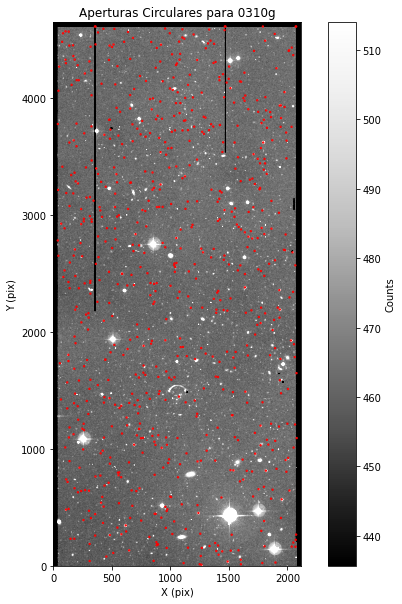

In [40]:
positions_g = np.transpose((sources_g['xcentroid'], sources_g['ycentroid']))
apertures1_g = CircularAperture(positions_g, r=6.)

fig, ax = plot_image(data_g)
ax.set_title('Aperturas Circulares para 0310g')
apertures1_g.plot(color='r', axes=ax)
None

In [41]:
phot_table_g = aperture_photometry(data_g, apertures1_g)
print(phot_table_g)

 id      xcenter            ycenter          aperture_sum   
           pix                pix                           
--- ------------------ ------------------ ------------------
  1  1265.112819061235  8.681405800501057  60898.18556829385
  2  1601.882138369255  12.47123197438311  53200.97290970766
  3 1250.2096191234778 12.962591118026888 53963.108516147724
  4 1112.7348123160195  22.29957453277451 53138.109628596125
  5 1785.0126062992713  23.33730692820389  54504.32791233694
  6 1897.1702790592774  27.67754351323391  51967.86976495116
  7 1488.7464571977775  35.92563482637287 148711.97557001607
  8 309.93191481543386  40.54517412207624  53429.70462274243
  9   856.387118818139  41.81535413220607 53392.395827399916
 10 1600.9237464618368 51.216202385339244  58557.00584598604
...                ...                ...                ...
708  520.8677247724848  4586.203227049587  53266.62786715197
709  427.4123871681356  4587.223846428621  52627.46139826193
710  954.7411722674755  

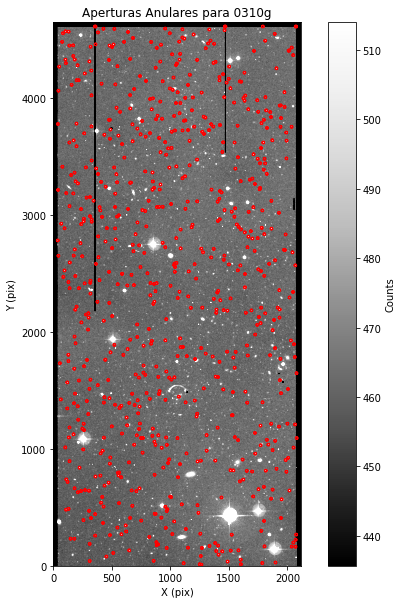

In [43]:
annulus_apertures_g = CircularAnnulus(positions_g, r_in=9, r_out=12)

fig, ax = plot_image(data_g)
ax.set_title('Aperturas Anulares para 0310g')
annulus_apertures_g.plot(color='r', axes=ax)
None

In [44]:
annulus_mask = annulus_apertures_g.to_mask(method='center')
bkg_median_g = [] 
for mask in annulus_mask: 
    annulus_data = mask.multiply(data_g) 
    annulus_data_1d = annulus_data[mask.data > 0] 
    _, median_sigclip ,_ = sigma_clipped_stats(annulus_data_1d) 
    bkg_median_g.append(median_sigclip)

bkg_median_g = np.array(bkg_median_g)

In [46]:
np.median(bkg_median_g)

462.4700012207031

In [47]:
def magnitud_sn_g(tabla):
    
    phot_table_g = tabla
    
    zp = 26.4600

    phot_table_g["total_bkg"] = bkg_median_g * apertures1_g.area
    phot_table_g["count_without_bkg"] = phot_table_g["aperture_sum"] - phot_table_g["total_bkg"] 

    phot_table_g['flux'] = (1.5300 * phot_table_g['count_without_bkg']) / 240.135 

    phot_table_g['mag_inst'] = -2.5 * np.log10(np.abs(phot_table_g['flux'])) 
    phot_table_g['mag_cal'] = phot_table_g['mag_inst'] + zp 

    phot_table_g["SN_g"] = phot_table_g["flux"] / np.sqrt(phot_table_g["flux"] + phot_table_g["total_bkg"])
    phot_table_g["error_g"] = 2.5 * np.log10(1 + 1 / np.abs(phot_table_g["SN_g"]))
    return phot_table_g

phot_table_g = magnitud_sn_g(phot_table_g)
phot_table_g

<QTable length=717>
  id       xcenter       ...          SN_g               error_g      
             pix         ...                                          
int32      float64       ...        float64              float64      
----- ------------------ ... --------------------- -------------------
    1  1265.112819061235 ...     0.253395383028605  1.7357234825559602
    2  1601.882138369255 ...  0.021714915465395463   4.181428976085052
    3 1250.2096191234778 ...   0.05282019195600815   3.248885576221488
    4 1112.7348123160195 ...  0.024869269892550224   4.037513589350688
    5 1785.0126062992713 ...   0.05797861037645216  3.1530227135789057
    6 1897.1702790592774 ... 0.0003694006822038851   8.581656764750422
    7 1488.7464571977775 ...     2.606568524098961  0.3525626038276455
    8 309.93191481543386 ...   0.04453344548430649  3.4255901333042265
    9   856.387118818139 ...   0.04846013870392315  3.3379181771653705
  ...                ... ...                   ...                 ...
  708  520.8677247724848 ...    0.0317333472197111  3.7801289603213535
  709  427.4123871681356 ...  0.009007705412040308   5.123200770546101
  710  954.7411722674755 ...  0.002277156804080835   6.608987238380126
  711 360.19131155851335 ...   -0.5782808815488681  1.0901136533411102
  712 1464.7605759659389 ...   -0.5834445335107282  1.0840081998116267
  713 1470.1765942096965 ...   -0.5867811064554538  1.0801022476193587
  714 1789.6541313743442 ...  -0.41442814630312436  1.3328291167006612
  715  354.9109651059278 ...   -0.5921592356804621  1.0738699830449328
  716  2069.939564325564 ...   -0.4626715979124934  1.2496849703590631
  717 2074.0605788475355 ...    14.604343385513927 0.07190865738504196

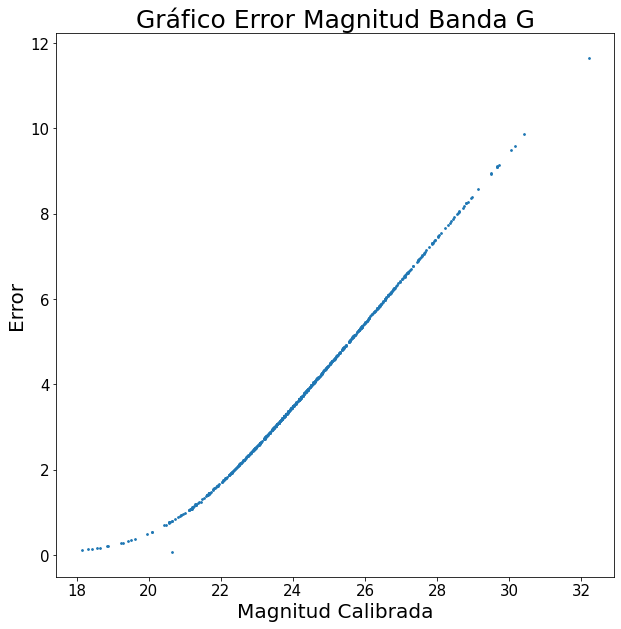

In [49]:

fig, ax = plt.subplots(figsize = (10, 10))
ax.scatter(phot_table_g["mag_cal"], phot_table_g["error_g"], s= 3) 
ax.set_title('Gráfico Error Magnitud Banda G', fontsize = 25)
ax.set_xlabel('Magnitud Calibrada', fontdict = {'fontsize':20})
ax.set_ylabel('Error', fontsize = 20)
ax.tick_params('both', labelsize=15)

-- -- -- -- -- -- --  Distintas Aperturas -- -- -- -- -- -- -- --

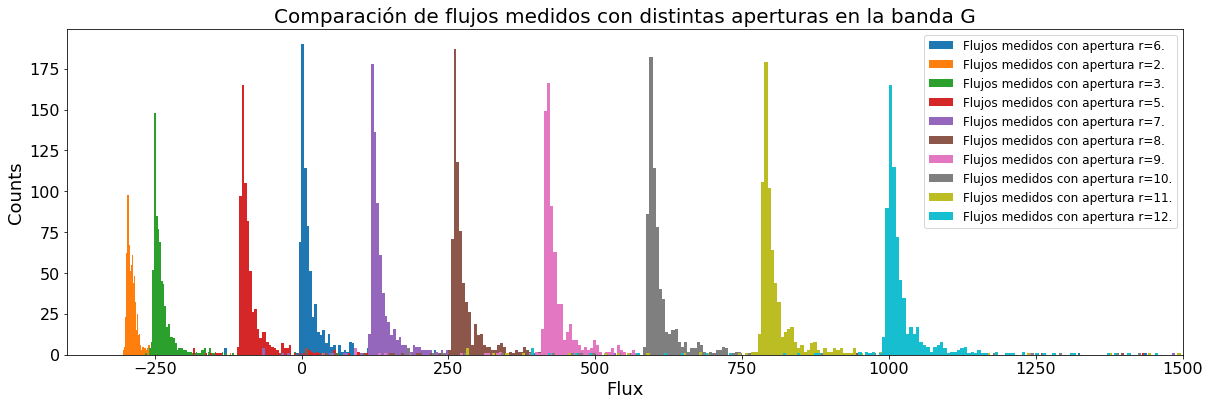

In [53]:
apertures2_g = CircularAperture(positions_g, r=2.)
apertures3_g = CircularAperture(positions_g, r=3.)
apertures4_g = CircularAperture(positions_g, r=5.)
apertures5_g = CircularAperture(positions_g, r=7.)
apertures6_g = CircularAperture(positions_g, r=8.)
apertures7_g = CircularAperture(positions_g, r=9.)
apertures8_g = CircularAperture(positions_g, r=10.)
apertures9_g = CircularAperture(positions_g, r=11.)
apertures10_g = CircularAperture(positions_g, r=12.)

phot_table_g_2 = aperture_photometry(data_g, apertures2_g)
phot_table_g_3 = aperture_photometry(data_g, apertures3_g)
phot_table_g_4 = aperture_photometry(data_g, apertures4_g)
phot_table_g_5 = aperture_photometry(data_g, apertures5_g)
phot_table_g_6 = aperture_photometry(data_g, apertures6_g)
phot_table_g_7 = aperture_photometry(data_g, apertures7_g)
phot_table_g_8 = aperture_photometry(data_g, apertures8_g)
phot_table_g_9 = aperture_photometry(data_g, apertures9_g)
phot_table_g_10 = aperture_photometry(data_g, apertures10_g)

phot_table_g_2 = magnitud_sn_g(phot_table_g_2)
phot_table_g_3 = magnitud_sn_g(phot_table_g_3)
phot_table_g_4 = magnitud_sn_g(phot_table_g_4)
phot_table_g_5 = magnitud_sn_g(phot_table_g_5)
phot_table_g_6 = magnitud_sn_g(phot_table_g_6)
phot_table_g_7 = magnitud_sn_g(phot_table_g_7)
phot_table_g_8 = magnitud_sn_g(phot_table_g_8)
phot_table_g_9 = magnitud_sn_g(phot_table_g_9)
phot_table_g_10 = magnitud_sn_g(phot_table_g_10)

fig, ax = plt.subplots(figsize = (20,6))
ax.hist(phot_table_g['flux'], bins=500, label='Flujos medidos con apertura r=6.')
ax.hist(phot_table_g_2['flux'], bins=500, label='Flujos medidos con apertura r=2.')
ax.hist(phot_table_g_3['flux'], bins=500, label='Flujos medidos con apertura r=3.')
ax.hist(phot_table_g_4['flux'], bins=500, label='Flujos medidos con apertura r=5.')
ax.hist(phot_table_g_5['flux'], bins=500, label='Flujos medidos con apertura r=7.')
ax.hist(phot_table_g_6['flux'], bins=500, label='Flujos medidos con apertura r=8.')
ax.hist(phot_table_g_7['flux'], bins=500, label='Flujos medidos con apertura r=9.')
ax.hist(phot_table_g_8['flux'], bins=500, label='Flujos medidos con apertura r=10.')
ax.hist(phot_table_g_9['flux'], bins=500, label='Flujos medidos con apertura r=11.')
ax.hist(phot_table_g_10['flux'], bins=500, label='Flujos medidos con apertura r=12.')
ax.set_title('Comparación de flujos medidos con distintas aperturas en la banda G', fontsize=20)
ax.set_xlabel('Flux',fontsize=18)
ax.set_ylabel('Counts', fontsize=18)
ax.tick_params('both', labelsize=16)
ax.set_xlim(-400,1500)
ax.legend(fontsize=12)

## Fotometría

### Banda R

In [54]:
daofind = DAOStarFinder(fwhm=1.5, threshold= 4.*std_r)  
sources_dao_r = daofind(data_r - median_r)
print(sources_dao_r)
print(sources_dao_r.columns)

 id      xcentroid      ...        flux                 mag         
---- ------------------ ... ------------------ ---------------------
   1  33.26141915141567 ... 5.3639020919799805   -1.8237021050420723
   2  2077.734875998389 ...  5.862339496612549   -1.9201774136405934
   3  277.7938877800795 ... 3.6682822704315186   -1.4111568669593566
   4 285.66276549869355 ... 1.2010152339935303  -0.19887129035857148
   5  857.7553246549018 ...    5.1653733253479   -1.7827542886368486
   6  864.2139647888489 ...  8.023798942565918    -2.260950094389033
   7 353.67318916516206 ...   2.00608229637146    -0.755871863245008
   8  1488.930901100185 ...  93.41891479492188    -4.926087044948598
   9  1601.125079548068 ... 3.5658485889434814   -1.3804072461572336
  10 1812.0810004100774 ...  1.022902011871338 -0.024585081978834654
 ...                ... ...                ...                   ...
1415 1331.7367828112494 ... 2.3633365631103516   -0.9338139349455818
1416  642.4991596551562 ... 1.0871

In [55]:
mask = np.zeros(data.shape, dtype=bool)
mask[100:275, 1800:1950] = True
mask[400:575, 1650:1825] = True
mask[380:500, 1440:1600] = True
mask[220:270, 1080:1120] = True
mask[500:530, 920:940] = True
mask[770:800, 1160:1200] = True
mask[840:900, 1540:1590] = True
mask[890:915, 1750:1780] = True
mask[360:390, 40:80] = True
mask[1025:1210, 200:280] = True
mask[1410:1550, 980:1150] = True
mask[1665:1800, 1900:2020] = True
mask[1920:2020, 490:540] = True
mask[2674:2780, 794:950] = True
mask[2613:2660, 976:1010] = True
mask[4300:4360, 1500:1590] = True
mask[3210:3250, 120:150] = True
mask[4030:4090, 1020:1050] = True
sources_r = daofind(data_r - median_r, mask=mask)
for col in sources_r.colnames:
    sources_r[col].info.format = '%.8g'

In [56]:
sources_r

<QTable length=1302>
  id  xcentroid ycentroid sharpness  ...    peak       flux       mag     
int32  float64   float64   float64   ...  float64    float64    float64   
----- --------- --------- ---------- ... ---------- --------- ------------
    1 33.261419 2.0944598 0.74081546 ... -10.099609 5.3639021   -1.8237021
    2 2077.7349 2.0050379 0.75974047 ...  65.650391 5.8623395   -1.9201774
    3 277.79389   7.02487 0.98296452 ...  512.07031 3.6682823   -1.4111569
    4 285.66277 12.805583 0.98928732 ...   123.2207 1.2010152  -0.19887129
    5 857.75532 19.148712 0.92486417 ...  709.01953 5.1653733   -1.7827543
    6 864.21396 21.444587 0.77115897 ...   1165.541 8.0237989   -2.2609501
    7 353.67319 24.851683 0.83594864 ...  260.58008 2.0060823  -0.75587186
    8 1488.9309 36.217274 0.65155621 ...   21437.25 93.418915    -4.926087
    9 1601.1251 51.432417  0.6849242 ...   855.4707 3.5658486   -1.3804072
   10  1812.081 55.102284 0.89001149 ...  127.25977  1.022902 -0.024585082
  ...       ...       ...        ... ...        ...       ...          ...
 1293 642.49916 4582.2693 0.82494144 ...  97.970703 1.0871317 -0.090705438
 1294 1315.1043 4589.6134 0.87034737 ...  787.80078 5.8825207   -1.9239087
 1295 1814.0108 4593.7006 0.97147831 ...  394.91016 2.7433956   -1.0957211
 1296 1204.6182 4600.6287  0.7676195 ...  88.880859 1.0774543 -0.080997176
 1297 1125.7831 4607.8982 0.89274702 ...  745.38086 5.6886024    -1.887514
 1298 33.230794 4608.8884 0.75304537 ...  38.380859 5.8702035   -1.9216329
 1299 359.12496 4608.7954 0.76516769 ...  24.240234 5.6142569   -1.8732307
 1300 2068.9706 4608.7522 0.72869579 ...  5.0507812 5.5327373   -1.8573501
 1301 2072.9989 4608.7429 0.71743033 ... -16.160156 5.4354963    -1.838098
 1302 2077.8404  4608.849  0.9872904 ...  62.621094 6.2010198   -1.9811578

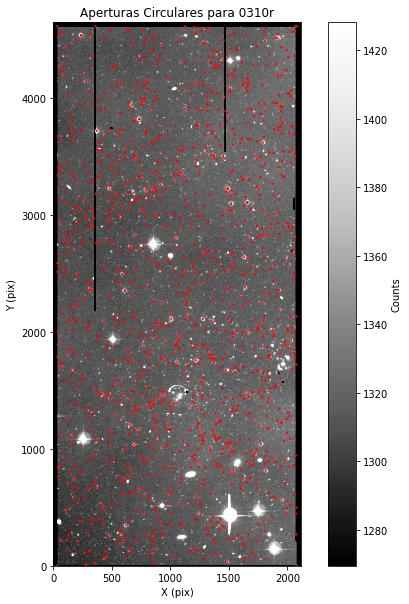

In [58]:
positions_r = np.transpose((sources_r['xcentroid'], sources_r['ycentroid']))
apertures1_r = CircularAperture(positions_r, r=6.)

fig, ax = plot_image(data_r)
ax.set_title('Aperturas Circulares para 0310r')
apertures1_r.plot(color='r', axes=ax)
None

In [59]:
phot_table_r = aperture_photometry(data_r, apertures1_r)
print(phot_table_r)


 id       xcenter            ycenter          aperture_sum   
            pix                pix                           
---- ------------------ ------------------ ------------------
   1  33.26141915141567 2.0944597622790275  66202.36330163611
   2  2077.734875998389 2.0050378689054416   66595.7836343159
   3  277.7938877800795  7.024869977887378 147126.23338173443
   4 285.66276549869355 12.805582633091856 146044.99382811744
   5  857.7553246549018 19.148711641234513 152636.68290393995
   6  864.2139647888489 21.444587209063485  156046.4020714931
   7 353.67318916516206 24.851683445558283 147470.49046793254
   8  1488.930901100185 36.217273941404265 509702.27753678185
   9  1601.125079548068  51.43241690773547 162731.05161632824
  10 1812.0810004100774 55.102283561998235 148981.38069478096
 ...                ...                ...                ...
1293  642.4991596551562  4582.269259001538 148227.21858179313
1294  1315.104278322304  4589.613428300468 150851.64486086147
1295 181

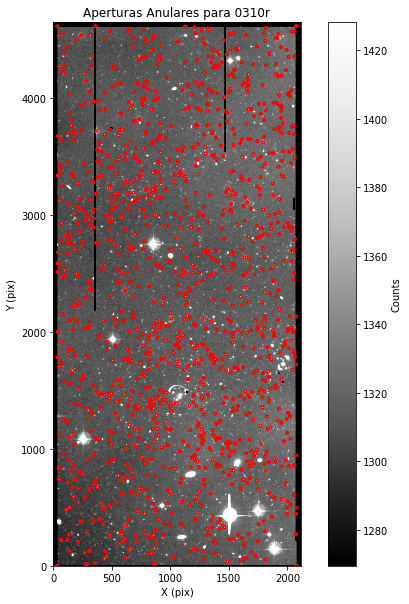

In [62]:
annulus_apertures_r = CircularAnnulus(positions_r, r_in=9, r_out=12)

fig, ax = plot_image(data_r)
ax.set_title('Aperturas Anulares para 0310r')
annulus_apertures_r.plot(color='r', axes=ax)
None

In [63]:
annulus_mask = annulus_apertures_r.to_mask(method='center')
bkg_median_r = [] 
for mask in annulus_mask: 
    annulus_data = mask.multiply(data_r) 
    annulus_data_1d = annulus_data[mask.data > 0] 
    _, median_sigclip ,_ = sigma_clipped_stats(annulus_data_1d) 
    bkg_median_r.append(median_sigclip)

bkg_median_r = np.array(bkg_median_r)

In [65]:
np.median(bkg_median_r)

1318.05078125

In [68]:
def magnitud_sn_r(tabla):
    
    phot_table_r = tabla
    
    zp = 25.9780

    phot_table_r["total_bkg"] = bkg_median_r * apertures1_r.area
    phot_table_r["count_without_bkg"] = phot_table_r["aperture_sum"] - phot_table_r["total_bkg"] 

    phot_table_r['flux'] = (1.5667 * phot_table_r['count_without_bkg']) / 480.105 

    phot_table_r['mag_inst'] = -2.5 * np.log10(np.abs(phot_table_r['flux'])) 
    phot_table_r['mag_cal'] = phot_table_r['mag_inst'] + zp 

    phot_table_r["SN_r"] = phot_table_r["flux"] / np.sqrt(phot_table_r["flux"] + phot_table_r["total_bkg"])
    phot_table_r["error_r"] = 2.5 * np.log10(1 + 1 / np.abs(phot_table_r["SN_r"]))
    return phot_table_r

phot_table_r = magnitud_sn_r(phot_table_r)
phot_table_r

<QTable length=1302>
  id       xcenter       ...          SN_r               error_r       
             pix         ...                                           
int32      float64       ...        float64              float64       
----- ------------------ ... --------------------- --------------------
    1  33.26141915141567 ...    14.698112050135347  0.07146467699171953
    2  2077.734875998389 ...    14.741720543226572  0.07126006045784956
    3  277.7938877800795 ...  0.025525388986682867    4.009935118940696
    4 285.66276549869355 ... -0.005320061176703568    5.690969306526115
    5  857.7553246549018 ...   0.04391081804366674     3.44022967565496
    6  864.2139647888489 ...   0.07387991041913816   2.9060733943089394
    7 353.67318916516206 ...  0.004876329257369204    5.785048984950595
    8  1488.930901100185 ...     2.969541449304735  0.31512737383358025
    9  1601.125079548068 ...   0.11748190002987077    2.445673839535267
  ...                ... ...                   ...                  ...
 1293  642.4991596551562 ... 0.0006172094303463334     8.02458853733122
 1294  1315.104278322304 ...  0.016046069643719445    4.503861818498253
 1295 1814.0108237154145 ...  0.009393876002209348    5.078039605693662
 1296 1204.6182088387327 ...  0.007823098265421482    5.275013805726366
 1297  1125.783139806581 ...  -0.25345212452254684    1.735529536993151
 1298  33.23079383334332 ...     14.70404925607512  0.07143674977564907
 1299  359.1249600084292 ...   -0.5255784147608331   1.1569925365836584
 1300 2068.9705743817453 ...   -0.4341904533878492   1.2973163924834086
 1301 2072.9989234257723 ...    17.438870781971147 0.060539902910037476
 1302  2077.840431646597 ...    14.850235585898043   0.0707559455474677

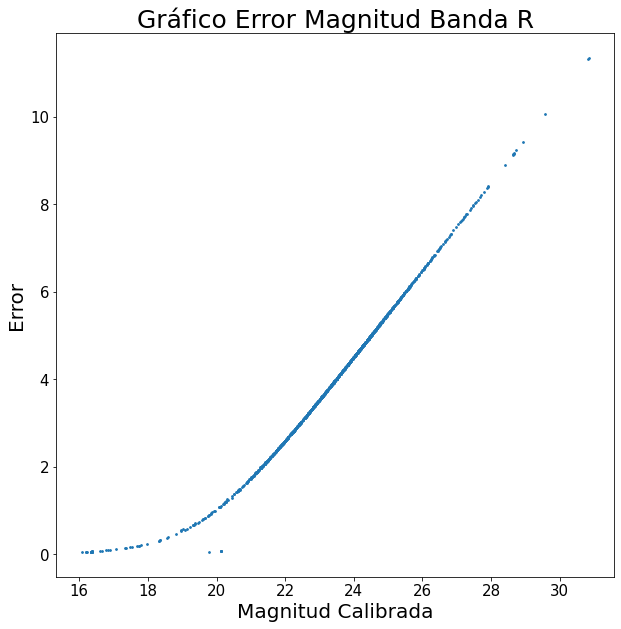

In [70]:
fig, ax = plt.subplots(figsize = (10, 10))
ax.scatter(phot_table_r["mag_cal"], phot_table_r["error_r"], s= 3) 
ax.set_title('Gráfico Error Magnitud Banda R', fontsize = 25)
ax.set_xlabel('Magnitud Calibrada', fontdict = {'fontsize':20})
ax.set_ylabel('Error', fontsize = 20)
ax.tick_params('both', labelsize=15)

-- -- -- -- -- -- --  Distintas aperturas  -- -- -- -- -- -- -- --

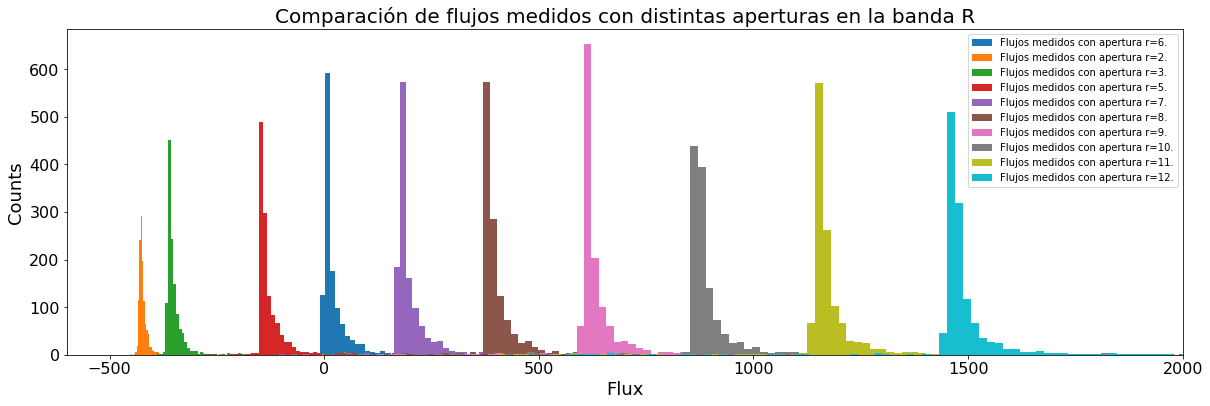

In [72]:
apertures2_r = CircularAperture(positions_r, r=2.)
apertures3_r = CircularAperture(positions_r, r=3.)
apertures4_r = CircularAperture(positions_r, r=5.)
apertures5_r = CircularAperture(positions_r, r=7.)
apertures6_r = CircularAperture(positions_r, r=8.)
apertures7_r = CircularAperture(positions_r, r=9.)
apertures8_r = CircularAperture(positions_r, r=10.)
apertures9_r = CircularAperture(positions_r, r=11.)
apertures10_r = CircularAperture(positions_r, r=12.)

phot_table_r_2 = aperture_photometry(data_r, apertures2_r)
phot_table_r_3 = aperture_photometry(data_r, apertures3_r)
phot_table_r_4 = aperture_photometry(data_r, apertures4_r)
phot_table_r_5 = aperture_photometry(data_r, apertures5_r)
phot_table_r_6 = aperture_photometry(data_r, apertures6_r)
phot_table_r_7 = aperture_photometry(data_r, apertures7_r)
phot_table_r_8 = aperture_photometry(data_r, apertures8_r)
phot_table_r_9 = aperture_photometry(data_r, apertures9_r)
phot_table_r_10 = aperture_photometry(data_r, apertures10_r)

phot_table_r_2 = magnitud_sn_r(phot_table_r_2)
phot_table_r_3 = magnitud_sn_r(phot_table_r_3)
phot_table_r_4 = magnitud_sn_r(phot_table_r_4)
phot_table_r_5 = magnitud_sn_r(phot_table_r_5)
phot_table_r_6 = magnitud_sn_r(phot_table_r_6)
phot_table_r_7 = magnitud_sn_r(phot_table_r_7)
phot_table_r_8 = magnitud_sn_r(phot_table_r_8)
phot_table_r_9 = magnitud_sn_r(phot_table_r_9)
phot_table_r_10 = magnitud_sn_r(phot_table_r_10)

fig, ax = plt.subplots(figsize = (20,6))
ax.hist(phot_table_r['flux'], bins=800, label='Flujos medidos con apertura r=6.')
ax.hist(phot_table_r_2['flux'], bins=800, label='Flujos medidos con apertura r=2.')
ax.hist(phot_table_r_3['flux'], bins=800, label='Flujos medidos con apertura r=3.')
ax.hist(phot_table_r_4['flux'], bins=800, label='Flujos medidos con apertura r=5.')
ax.hist(phot_table_r_5['flux'], bins=800, label='Flujos medidos con apertura r=7.')
ax.hist(phot_table_r_6['flux'], bins=800, label='Flujos medidos con apertura r=8.')
ax.hist(phot_table_r_7['flux'], bins=800, label='Flujos medidos con apertura r=9.')
ax.hist(phot_table_r_8['flux'], bins=800, label='Flujos medidos con apertura r=10.')
ax.hist(phot_table_r_9['flux'], bins=800, label='Flujos medidos con apertura r=11.')
ax.hist(phot_table_r_10['flux'], bins=800, label='Flujos medidos con apertura r=12.')
ax.set_title('Comparación de flujos medidos con distintas aperturas en la banda R', fontsize=20)
ax.set_xlabel('Flux',fontsize=18)
ax.set_ylabel('Counts', fontsize=18)
ax.tick_params('both', labelsize=16)
ax.set_xlim(-600,2000)
ax.legend(fontsize=10)


## Diagrama color magnitud

   * B - R
   * y: color, x: magnitud
   * g - r - i - z (menos a mas rojo)

In [75]:
annulus_mask = annulus_apertures_r.to_mask(method='center')
bkg_median_c = [] 
for mask in annulus_mask: 
    annulus_data = mask.multiply(data_g) 
    annulus_data_1d = annulus_data[mask.data > 0] 
    _, median_sigclip ,_ = sigma_clipped_stats(annulus_data_1d) 
    bkg_median_c.append(median_sigclip)

bkg_median_c = np.array(bkg_median_c)

In [76]:
phot_table_c = aperture_photometry(data_g, apertures1_r)
print(phot_table_c)

 id       xcenter            ycenter          aperture_sum   
            pix                pix                           
---- ------------------ ------------------ ------------------
   1  33.26141915141567 2.0944597622790275 22882.334955288996
   2  2077.734875998389 2.0050378689054416 30043.006794567584
   3  277.7938877800795  7.024869977887378 51781.857906372374
   4 285.66276549869355 12.805582633091856 51736.038340814215
   5  857.7553246549018 19.148711641234513 52023.395145290226
   6  864.2139647888489 21.444587209063485  51754.31916528288
   7 353.67318916516206 24.851683445558283  52160.33460408377
   8  1488.930901100185 36.217273941404265  148637.8114283746
   9  1601.125079548068  51.43241690773547  58549.48551932137
  10 1812.0810004100774 55.102283561998235 52412.577970696555
 ...                ...                ...                ...
1293  642.4991596551562  4582.269259001538  52790.50175188581
1294  1315.104278322304  4589.613428300468  52583.97539493139
1295 181

In [77]:
zp = 25.9780

phot_table_c["total_bkg"] = bkg_median_c * apertures1_r.area
phot_table_c["count_without_bkg"] = phot_table_c["aperture_sum"] - phot_table_c["total_bkg"] 
phot_table_c['flux'] = (1.5667 * phot_table_c['count_without_bkg']) / 240.135 

phot_table_c['mag_inst'] = -2.5 * np.log10(np.abs(phot_table_c['flux'])) 
phot_table_c['mag_cal'] = phot_table_c['mag_inst'] + zp
phot_table_c

<QTable length=1302>
  id       xcenter       ...       mag_inst           mag_cal      
             pix         ...                                       
int32      float64       ...       float64            float64      
----- ------------------ ... ------------------- ------------------
    1  33.26141915141567 ...  -5.435076795835588 20.542923204164413
    2  2077.734875998389 ...  -5.730684439389466 20.247315560610534
    3  277.7938877800795 ... -1.7371081821176413  24.24089181788236
    4 285.66276549869355 ...   2.570483425213927 28.548483425213927
    5  857.7553246549018 ... -1.3566035778160501 24.621396422183953
    6  864.2139647888489 ... -1.1283368044708595 24.849663195529143
    7 353.67318916516206 ... -1.3973526097354327  24.58064739026457
    8  1488.930901100185 ...  -6.982562265397059 18.995437734602945
    9  1601.125079548068 ... -4.0252197504420675 21.952780249557932
  ...                ... ...                 ...                ...
 1293  642.4991596551562 ...  -1.486879673614103   24.4911203263859
 1294  1315.104278322304 ... -0.6536411466490759 25.324358853350926
 1295 1814.0108237154145 ... -1.0626707545653966 24.915329245434606
 1296 1204.6182088387327 ... -1.8637667761593062 24.114233223840696
 1297  1125.783139806581 ...  -5.224549029880333  20.75345097011967
 1298  33.23079383334332 ...  -4.898051634123906 21.079948365876096
 1299  359.1249600084292 ...  -5.264623273307722  20.71337672669228
 1300 2068.9705743817453 ...  -5.426532096419826 20.551467903580175
 1301 2072.9989234257723 ...  -5.417615770346735 20.560384229653266
 1302  2077.840431646597 ...  -5.208074717817407 20.769925282182594

Text(0, 0.5, 'Color (G - R)')

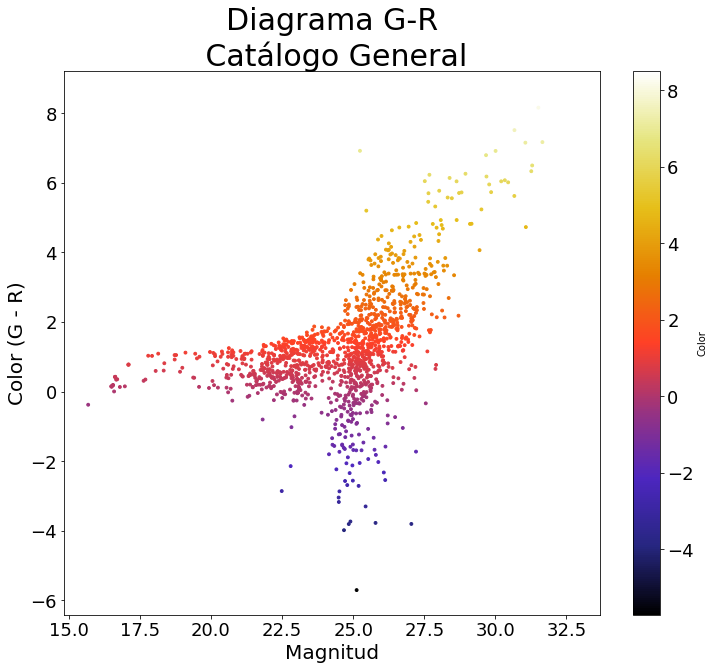

In [85]:
fig, ax = plt.subplots(figsize = (12, 10))
im = ax.scatter(phot_table_c["mag_cal"], phot_table_c["mag_cal"] - phot_table_r["mag_cal"], s=8,cmap = 'CMRmap', c=phot_table_c["mag_cal"] - phot_table_r["mag_cal"], alpha=1)
cbar = plt.colorbar(im, ax=ax, label='Color')
cbar.ax.tick_params('both', labelsize=18)



ax.tick_params(labelsize=18)
ax.set_title('Diagrama G-R\n Catálogo General', fontsize = 30)
ax.set_xlabel('Magnitud', fontsize = 20)
ax.set_ylabel('Color (G - R)', fontdict = {'fontsize':20})

## Magnitudes para detectar objetos con señales a ruido entre 3 y 5

### Banda G

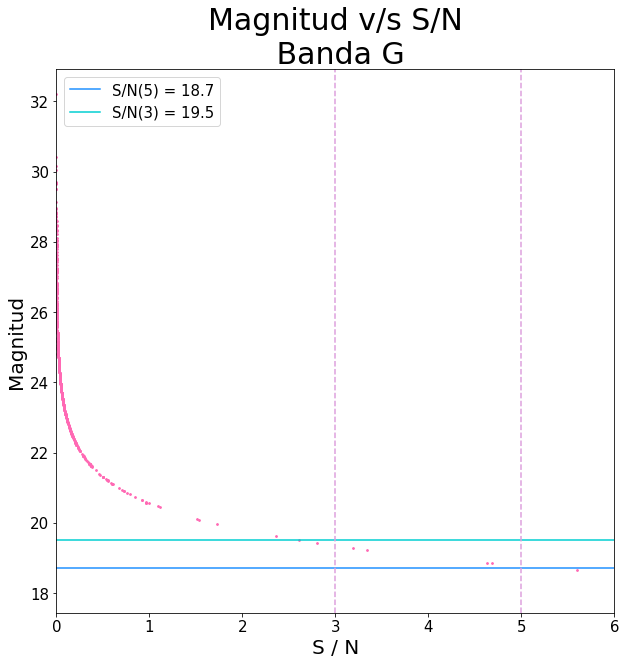

In [73]:
fig, ax = plt.subplots(figsize = (10, 10))
ax.scatter(phot_table_g["SN_g"], phot_table_g["mag_cal"], s= 3, c="hotpink") 
ax.set_xlim(0, 6)
ax.axhline(18.7, c='dodgerblue', label = "S/N(5) = 18.7")
ax.axhline(19.5, c='darkturquoise', label = "S/N(3) = 19.5")
ax.axvline(3, c='plum', linestyle="dashed")
ax.axvline(5, c='plum', linestyle="dashed")
ax.set_title('Magnitud v/s S/N\n Banda G', fontsize = 30)
ax.set_xlabel('S / N', fontsize = 20)
ax.set_ylabel('Magnitud', fontdict = {'fontsize':20})
ax.tick_params('both',labelsize=15)
ax.legend(fontsize=15)

### Banda R

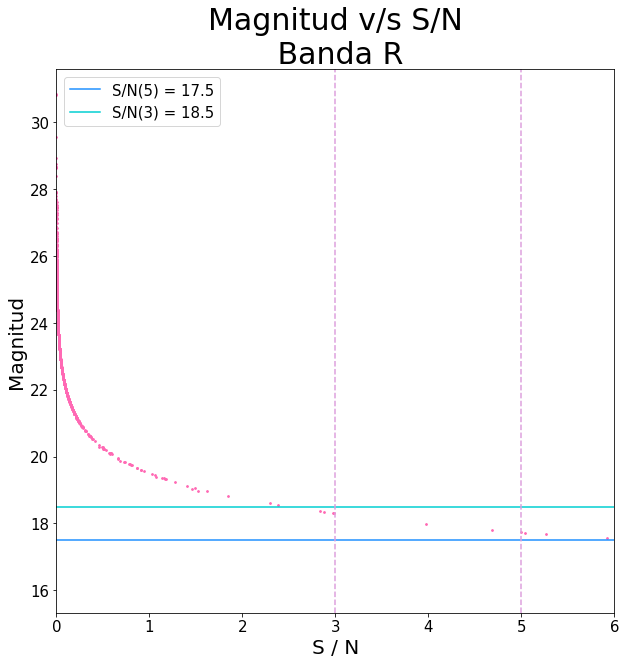

In [74]:
fig, ax = plt.subplots(figsize = (10, 10))
ax.scatter(phot_table_r["SN_r"], phot_table_r["mag_cal"], s= 3, c="hotpink") 
ax.set_xlim(0, 6)
ax.axhline(17.5, c='dodgerblue', label = "S/N(5) = 17.5")
ax.axhline(18.5, c='darkturquoise', label = "S/N(3) = 18.5")
ax.axvline(3, c='plum', linestyle="dashed")
ax.axvline(5, c='plum', linestyle="dashed")
ax.set_title('Magnitud v/s S/N\n Banda R', fontsize = 30)
ax.set_xlabel('S / N', fontsize = 20)
ax.set_ylabel('Magnitud', fontdict = {'fontsize':20})
ax.tick_params('both',labelsize=15)
ax.legend(fontsize=15)

## Centro del cúmulo

centro: x=1084 y=1442

In [86]:
mask_centro_g = data_g[1292:1592,934:1234] # ± 150 píxeles
mask_centro_r = data_r[1292:1592,934:1234]

Text(0, 0.5, 'Y (pix)')

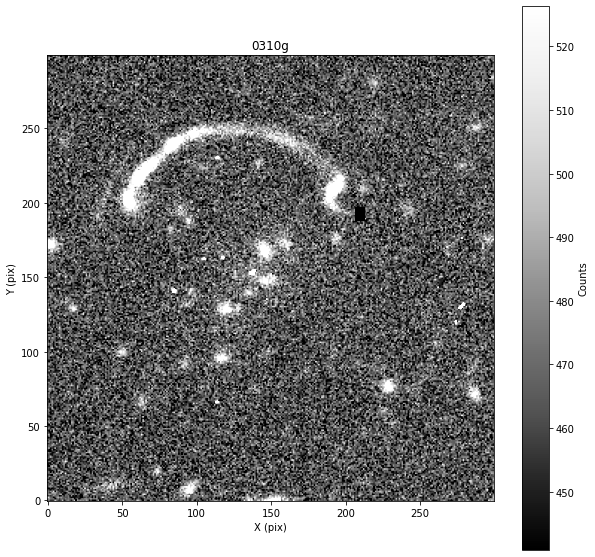

In [87]:
norm = simple_norm(mask_centro_g, min_percent=10, max_percent=99)
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(mask_centro_g, norm=norm, origin="lower", cmap="Greys_r")
fig.colorbar(im, ax=ax, label="Counts")
ax.set_title("0310g")
ax.set_xlabel("X (pix)")
ax.set_ylabel("Y (pix)")


Text(0, 0.5, 'Y (pix)')

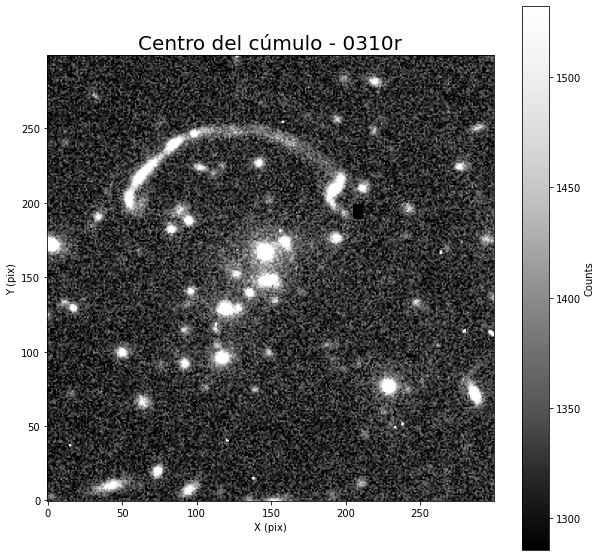

In [91]:
norm = simple_norm(mask_centro_r, min_percent=10, max_percent=99)
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(mask_centro_r, norm=norm, origin="lower", cmap="Greys_r")
fig.colorbar(im, ax=ax, label="Counts")
ax.set_title("Centro del cúmulo - 0310r", fontsize=20)
ax.set_xlabel("X (pix)")
ax.set_ylabel("Y (pix)")

In [89]:
def mean_median_std(data):
    mean, median, std = sigma_clipped_stats(data, sigma=4.0)
    return mean, median, std

mean_cg, median_cg, std_cg = mean_median_std(mask_centro_g)
mean_cr, median_cr, std_cr = mean_median_std(mask_centro_r)

print(mean_cg, median_cg, std_cg)
print(mean_cr, median_cr, std_cr)

465.1952 464.53 19.263102
1328.2802 1326.1309 35.25605


In [90]:
daofind_center = DAOStarFinder(fwhm=9, threshold= 4.*std_cg)  
sources_dao_cg = daofind_center(mask_centro_g - median_cg)
print(sources_dao_cg)
print(sources_dao_cg.columns)

 id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1  135.4211037924901 ... 1.0959343910217285 -0.09946138886059748
  2  94.89672294006262 ... 2.3700852394104004  -0.9369099139069904
  3  73.52012494398397 ... 1.7473273277282715  -0.6059356730328764
  4  63.24080085130797 ... 1.2828575372695923 -0.27044607544048865
  5  286.5304654006477 ...  2.638695001602173  -1.0534729859933454
  6 228.51337202299183 ...  3.258455991744995   -1.282529649625369
  7   92.1959099141687 ... 1.2232915163040161 -0.21882490963048493
  8 116.70425973280568 ... 2.6703615188598633  -1.0664251524915827
  9  49.75858311664081 ... 1.9743311405181885  -0.7385499889176134
 10 125.98582561682105 ... 1.2377419471740723 -0.23157527366464964
...                ... ...                ...                  ...
 17 2.2678047428849766 ...  4.207280158996582  -1.5600035806457613
 18  159.5537921835628 ...  1.937546968460083  -0.718130597811

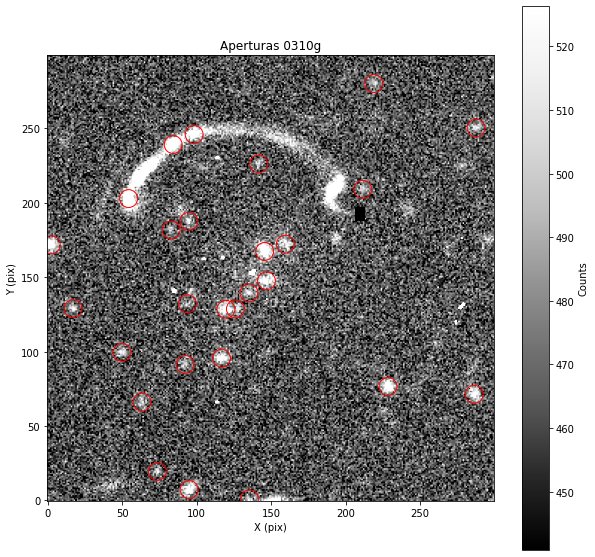

In [93]:
positions_cg = np.transpose((sources_dao_cg['xcentroid'], sources_dao_cg['ycentroid']))
apertures_cg = CircularAperture(positions_cg, r=6.)

fig, ax = plot_image(mask_centro_g)
ax.set_title('Aperturas 0310g')
apertures_cg.plot(color='r', axes=ax)
None

In [94]:
phot_table_cg = aperture_photometry(mask_centro_g, apertures_cg)
print(phot_table_cg)

 id      xcenter            ycenter          aperture_sum   
           pix                pix                           
--- ------------------ ------------------ ------------------
  1  135.4211037924901 1.1058014130509428 36050.841015119615
  2  94.89672294006262  7.343464673263531  56321.61133977948
  3  73.52012494398397 19.493679102915817  53324.93370120545
  4  63.24080085130797  66.15488579944616  54002.44998406469
  5  286.5304654006477  71.34836885078498 55902.599515237736
  6 228.51337202299183  76.58875481674517  57094.79231933347
  7   92.1959099141687   91.3986206548176    53913.295657208
  8 116.70425973280568  95.62012063662736  56036.56182762615
  9  49.75858311664081   99.4606588347242 54024.048163038744
 10 125.98582561682105  128.7042251074614  55364.88019170795
...                ...                ...                ...
 18  159.5537921835628 172.22906625594905  55398.43896804156
 19  82.81778981889526 181.75697723782486  53290.32286150122
 20  94.71089769923887 1

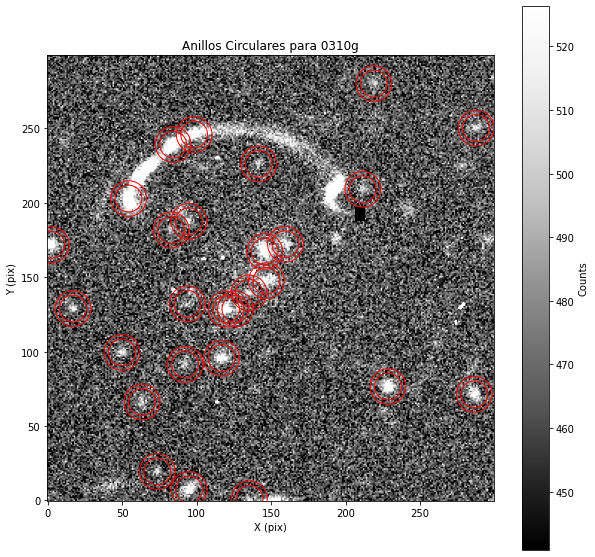

In [95]:
annulus_apertures_cg = CircularAnnulus(positions_cg, r_in=9, r_out=12)

fig, ax = plot_image(mask_centro_g)
ax.set_title('Anillos Circulares para 0310g')
annulus_apertures_cg.plot(color='r', axes=ax)
None 

In [96]:
daofind_center = DAOStarFinder(fwhm=9, threshold= 4.*std_cr)  
sources_dao_cr = daofind_center(mask_centro_r - median_cr)
print(sources_dao_cr)
print(sources_dao_cr.columns)

 id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1 135.48739488459188 ... 1.4508029222488403  -0.4040210541941858
  2  2.472001348156232 ... 1.1020517349243164 -0.10550495649079611
  3   94.8979167100998 ...  4.407916069030762   -1.610583291342632
  4  43.28282182818541 ...  4.305706977844238  -1.5851111771444417
  5 210.42240025069668 ... 2.2871625423431396   -0.898242574540788
  6 138.19677252752788 ...  1.815961480140686  -0.6477665802592402
  7  73.76439871596264 ...  6.547617435455322   -2.040208241249418
  8 213.00129042517798 ... 1.3954976797103882  -0.3618227968129457
  9  63.84752821885565 ...  3.317387342453003   -1.301990458169169
 10  286.8274714269117 ... 12.168022155761719  -2.7130499795428893
...                ... ...                ...                  ...
 57 141.79405653717248 ...  4.808661460876465  -1.7050605074336422
 58   84.3405389881121 ...   9.14693546295166  -2.403189037227

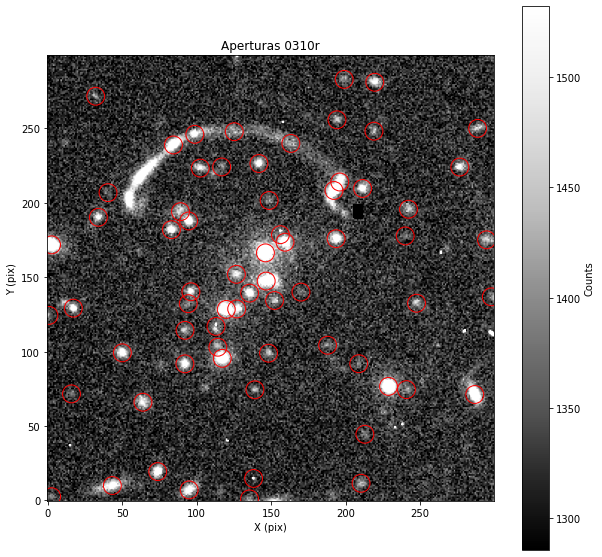

In [97]:
positions_cr = np.transpose((sources_dao_cr['xcentroid'], sources_dao_cr['ycentroid']))
apertures_cr = CircularAperture(positions_cr, r=6.)

fig, ax = plot_image(mask_centro_r)
ax.set_title('Aperturas 0310r')
apertures_cr.plot(color='r', axes=ax)
None

In [98]:
phot_table_cr = aperture_photometry(mask_centro_r, apertures_cr)
print(phot_table_cr)

 id      xcenter            ycenter          aperture_sum   
           pix                pix                           
--- ------------------ ------------------ ------------------
  1 135.48739488459188 1.0448387263206398 100958.54747533004
  2  2.472001348156232  2.511283187783203  96021.68210800679
  3   94.8979167100998  7.083471724620856 161289.41717060166
  4  43.28282182818541 10.041636478835226 163392.78144983097
  5 210.42240025069668 11.528517770223418 153400.16821622214
  6 138.19677252752788 14.798722722877732 150526.58035652072
  7  73.76439871596264 19.401737917461396  161232.3530488392
  8 213.00129042517798  44.49733834313931 151372.41086630293
  9  63.84752821885565  66.01463958275946 159236.05284369076
 10  286.8274714269117  71.19364606953054 175094.37688951532
...                ...                ...                ...
 58   84.3405389881121 238.91393726055296 170692.21563705488
 59  163.2445795850587 239.93993977835876 156294.98854229608
 60  98.69381509438837 2

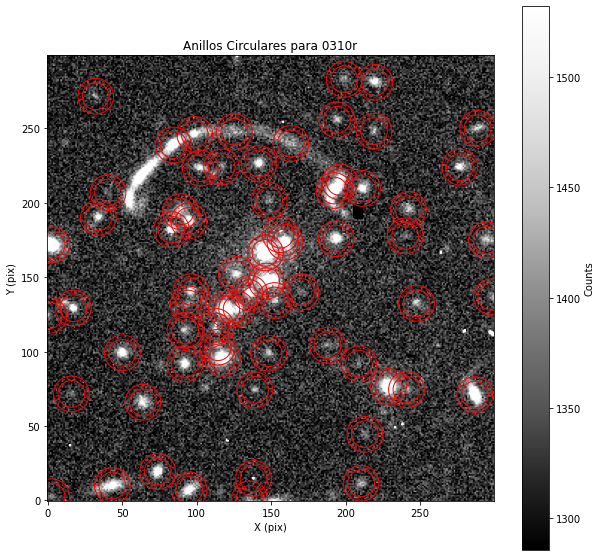

In [99]:
annulus_apertures_cr = CircularAnnulus(positions_cr, r_in=9, r_out=12)

fig, ax = plot_image(mask_centro_r)
ax.set_title('Anillos Circulares para 0310r')
annulus_apertures_cr.plot(color='r', axes=ax)
None 

In [100]:
annulus_mask = annulus_apertures_cr.to_mask(method='center')
bkg_median_cr = [] 
for mask in annulus_mask: 
    annulus_data = mask.multiply(mask_centro_r) 
    annulus_data_1d = annulus_data[mask.data > 0] 
    _, median_sigclip ,_ = sigma_clipped_stats(annulus_data_1d) 
    bkg_median_cr.append(median_sigclip)

bkg_median_cr = np.array(bkg_median_cr)

In [101]:
def magnitud_sn_r(tabla):
    
    phot_table_r = tabla
    
    zp = 25.9780

    phot_table_r["total_bkg"] = bkg_median_cr * apertures_cr.area
    phot_table_r["count_without_bkg"] = phot_table_r["aperture_sum"] - phot_table_r["total_bkg"] 

    phot_table_r['flux'] = (1.5667 * phot_table_r['count_without_bkg']) / 480.105 

    phot_table_r['mag_inst'] = -2.5 * np.log10(np.abs(phot_table_r['flux'])) 
    phot_table_r['mag_cal'] = phot_table_r['mag_inst'] + zp 

    phot_table_r["SN_r"] = phot_table_r["flux"] / np.sqrt(phot_table_r["flux"] + phot_table_r["total_bkg"])
    phot_table_r["error_r"] = 2.5 * np.log10(1 + 1 / np.abs(phot_table_r["SN_r"]))
    return phot_table_r

phot_table_cr = magnitud_sn_r(phot_table_cr)
phot_table_cr

<QTable length=67>
  id       xcenter       ...         SN_r               error_r      
             pix         ...                                         
int32      float64       ...       float64              float64      
----- ------------------ ... -------------------- -------------------
    1 135.48739488459188 ... -0.37061927344581747  1.4199720854218159
    2  2.472001348156232 ...   17.701475246012706 0.05966601162562671
    3   94.8979167100998 ...  0.10730518838652735  2.5341165337655402
    4  43.28282182818541 ...   0.1029709638180889   2.574623254510228
    5 210.42240025069668 ... 0.029775668016730993   3.847202780650027
    6 138.19677252752788 ... 0.010387168033097593   4.969976661916144
    7  73.76439871596264 ...  0.09578542644981317  2.6460652076504445
    8 213.00129042517798 ... 0.013651687521360274   4.676756021837813
    9  63.84752821885565 ...  0.07896165037316051  2.8389744796731833
  ...                ... ...                  ...                 ...
   58   84.3405389881121 ...  0.16831262119095422  2.1036059622642638
   59  163.2445795850587 ... 0.040479996371583275   3.524983175613717
   60  98.69381509438837 ...  0.07484786678169374   2.892918929285448
   61 125.21992757116892 ...  0.04057304191231358  3.5225875021301327
   62 219.08905391303435 ...  0.02216500487979306   4.159632942501748
   63 288.76626142389307 ...   0.0398678199016088  3.5408891271863965
   64   194.255493139756 ... 0.027734801358726108   3.922140008014333
   65  32.10245672281191 ... 0.028295255339807746   3.901010536286738
   66 219.66369196643512 ...  0.06515531045671977  3.0336577961299698
   67 199.08974963633912 ...  0.03196950752140147  3.7723272970951522

## Diagrama color-magnitud centro del cúmulo

In [102]:
annulus_mask = annulus_apertures_cr.to_mask(method='center')
bkg_median_cc = [] 
for mask in annulus_mask: 
    annulus_data = mask.multiply(mask_centro_g) 
    annulus_data_1d = annulus_data[mask.data > 0] 
    _, median_sigclip ,_ = sigma_clipped_stats(annulus_data_1d) 
    bkg_median_cc.append(median_sigclip)

bkg_median_cc = np.array(bkg_median_cc)

In [103]:
phot_table_cc = aperture_photometry(mask_centro_g, apertures_cr)
print(phot_table_cc)

 id      xcenter            ycenter          aperture_sum   
           pix                pix                           
--- ------------------ ------------------ ------------------
  1 135.48739488459188 1.0448387263206398 35729.233244546325
  2  2.472001348156232  2.511283187783203  33457.23701230024
  3   94.8979167100998  7.083471724620856  56284.00458311637
  4  43.28282182818541 10.041636478835226  54360.76505961948
  5 210.42240025069668 11.528517770223418   52872.6452565767
  6 138.19677252752788 14.798722722877732  52491.52957521308
  7  73.76439871596264 19.401737917461396  53316.14851365538
  8 213.00129042517798  44.49733834313931  52829.83691473656
  9  63.84752821885565  66.01463958275946  54020.40634593993
 10  286.8274714269117  71.19364606953054  55863.46113405617
...                ...                ...                ...
 58   84.3405389881121 238.91393726055296  63365.52647160137
 59  163.2445795850587 239.93993977835876   55811.1181790321
 60  98.69381509438837 2

In [104]:
phot_table_cc["total_bkg"] = bkg_median_cc*apertures_cr.area
phot_table_cc["count_without_bkg"] = phot_table_cc["aperture_sum"]-phot_table_cc["total_bkg"] 
phot_table_cc['flux'] = (1.6755 * phot_table_cc['count_without_bkg']) / 240 

phot_table_cc['mag_inst'] = -2.5 * np.log10(phot_table_cc['flux']) 
phot_table_cc['mag_cal'] = phot_table_cc['mag_inst'] + zp 
phot_table_cc

C:\Users\56974\AppData\Local\Temp\ipykernel_33180\2757750061.py:5: RuntimeWarning: invalid value encountered in log10
  phot_table_cc['mag_inst'] = -2.5 * np.log10(phot_table_cc['flux'])


<QTable length=67>
  id       xcenter       ...       mag_inst           mag_cal      
             pix         ...                                       
int32      float64       ...       float64            float64      
----- ------------------ ... ------------------- ------------------
    1 135.48739488459188 ...                 nan                nan
    2  2.472001348156232 ...  -5.921058158431098 20.056941841568904
    3   94.8979167100998 ... -3.7851739103707702 22.192826089629232
    4  43.28282182818541 ...  -2.441842084633306 23.536157915366694
    5 210.42240025069668 ... -1.4966980250352386  24.48130197496476
    6 138.19677252752788 ...  0.7633285319608274  26.74132853196083
    7  73.76439871596264 ... -2.2957391186320226  23.68226088136798
    8 213.00129042517798 ... -1.4117027320878286 24.566297267912173
    9  63.84752821885565 ... -2.6199913219339983 23.358008678066003
  ...                ... ...                 ...                ...
   58   84.3405389881121 ...  -4.598537092084079 21.379462907915922
   59  163.2445795850587 ...  -3.136806560329346 22.841193439670654
   60  98.69381509438837 ... -3.9934424090449583 21.984557590955042
   61 125.21992757116892 ... -2.9766287093697343 23.001371290630267
   62 219.08905391303435 ... -1.7200133117908112  24.25798668820919
   63 288.76626142389307 ... -2.7253953564067213  23.25260464359328
   64   194.255493139756 ...  -0.995323293162643  24.98267670683736
   65  32.10245672281191 ...                 nan                nan
   66 219.66369196643512 ...  -2.285579361786746 23.692420638213257
   67 199.08974963633912 ... -1.8229938387076259 24.155006161292377

Text(0, 0.5, 'Color (G - R)')

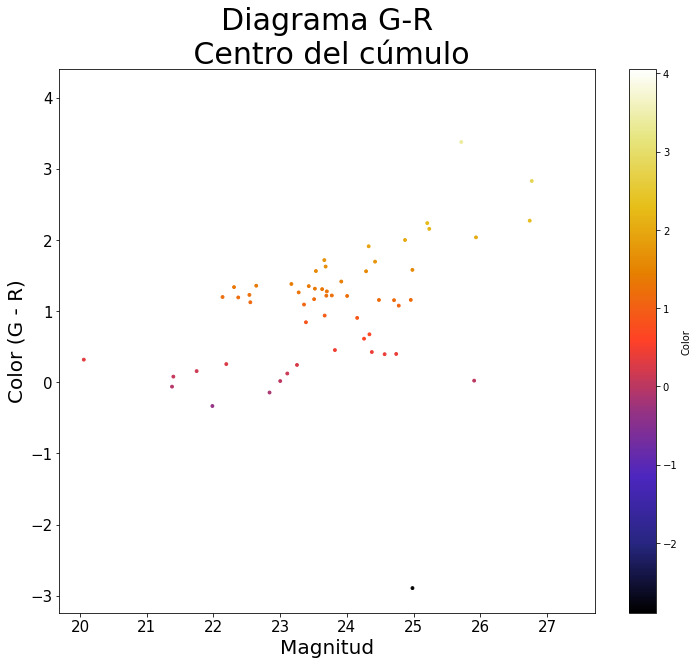

In [105]:
fig, ax = plt.subplots(figsize = (12, 10))
im = ax.scatter(phot_table_cc["mag_cal"], phot_table_cc["mag_cal"] - phot_table_cr["mag_cal"], s=8,cmap='CMRmap', c=phot_table_cc["mag_cal"] - phot_table_cr["mag_cal"], alpha=1)
cbar = plt.colorbar(im, ax=ax, label='Color')

ax.tick_params('both',labelsize=15)
ax.set_title('Diagrama G-R\n Centro del cúmulo', fontsize = 30)
ax.set_xlabel('Magnitud', fontsize = 20)
ax.set_ylabel('Color (G - R)', fontdict = {'fontsize':20})

### Imágenes con Coordenadas (Para uso del informe)

In [ ]:
path_g = '0310g.fits'
path_r = '0310r.fits'
hdulist_g = fits.open(path_g)
hdulist_r = fits.open(path_r)
files = [hdulist_g, hdulist_r]

In [89]:
WCS_g = WCS(hdulist_g[0].header)
WCS_r = WCS(hdulist_r[0].header)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


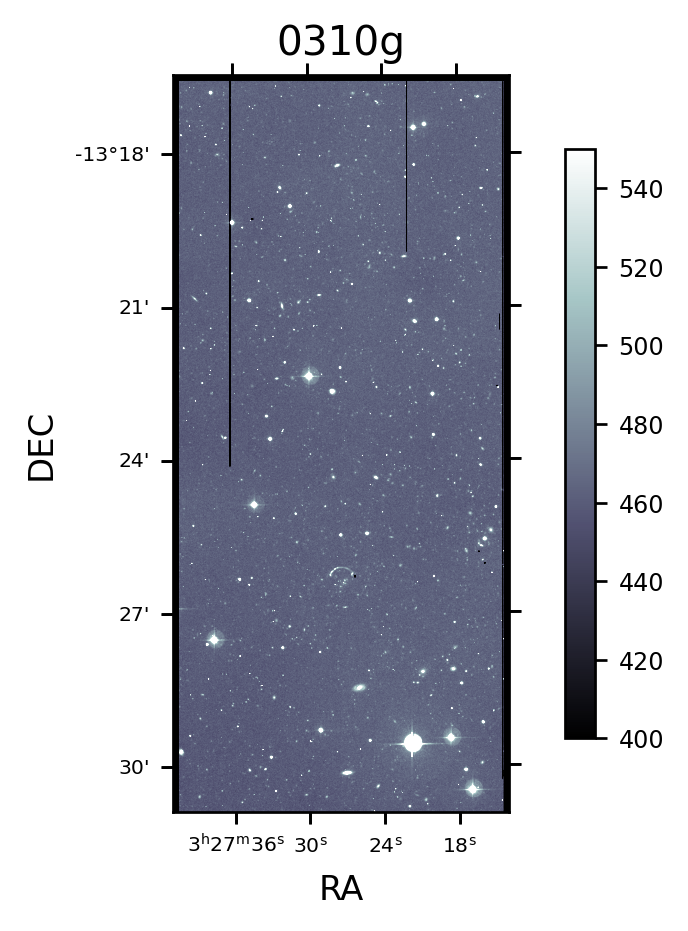

In [129]:
fig = plt.figure(dpi=244)
ax1 = fig.add_subplot(111, projection=WCS_g)
norm = ImageNormalize(hdulist_g[0].data, vmin=400, vmax=550)
im = ax1.imshow(hdulist_g[0].data, origin='lower', norm=norm, cmap='bone')
ax1.set_ylabel('DEC')
ax1.set_xlabel('RA')
ax1.set_title('0310g')
ax1.tick_params('both', labelsize=6)
cbar = plt.colorbar(im, ax=ax1, shrink=0.8)
cbar.ax.tick_params(labelsize=7) 


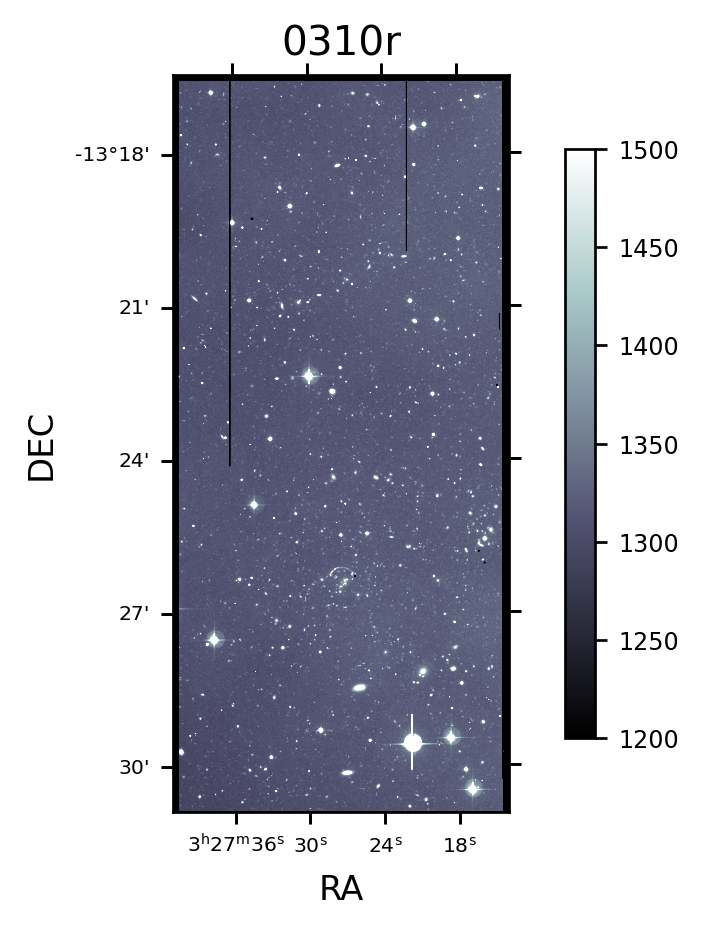

In [130]:
fig = plt.figure(dpi=244)
ax1 = fig.add_subplot(111, projection=WCS_r)
norm = ImageNormalize(hdulist_r[0].data, vmin=1200, vmax=1500)
im = ax1.imshow(hdulist_r[0].data, origin='lower', norm=norm, cmap='bone')
ax1.set_ylabel('DEC')
ax1.set_xlabel('RA')
ax1.set_title('0310r')
ax1.tick_params('both', labelsize=6)
cbar = plt.colorbar(im, ax=ax1, shrink=0.8)
cbar.ax.tick_params(labelsize=7) 